<a href="https://colab.research.google.com/github/HarshAhalpara-001/Autoencoder-MNIST-Label-to-Image/blob/main/MNIST_Autoencoder_LabelGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.05MB/s]


______________________________
Epoch 1/20
Batch 0/938, Running Loss: 0.230930
Batch 100/938, Running Loss: 0.065493
Batch 200/938, Running Loss: 0.054838
Batch 300/938, Running Loss: 0.041977
Batch 400/938, Running Loss: 0.035891
Batch 500/938, Running Loss: 0.028945
Batch 600/938, Running Loss: 0.031549
Batch 700/938, Running Loss: 0.029532
Batch 800/938, Running Loss: 0.026872
Batch 900/938, Running Loss: 0.025724
Average Loss: 0.041836
______________________________
Epoch 2/20
Batch 0/938, Running Loss: 0.025252
Batch 100/938, Running Loss: 0.024299
Batch 200/938, Running Loss: 0.021137
Batch 300/938, Running Loss: 0.020167
Batch 400/938, Running Loss: 0.020818
Batch 500/938, Running Loss: 0.018623
Batch 600/938, Running Loss: 0.016823
Batch 700/938, Running Loss: 0.018646
Batch 800/938, Running Loss: 0.020161
Batch 900/938, Running Loss: 0.018009
Average Loss: 0.020276
______________________________
Epoch 3/20
Batch 0/938, Running Loss: 0.016540
Batch 100/938, Running Loss: 0.01479

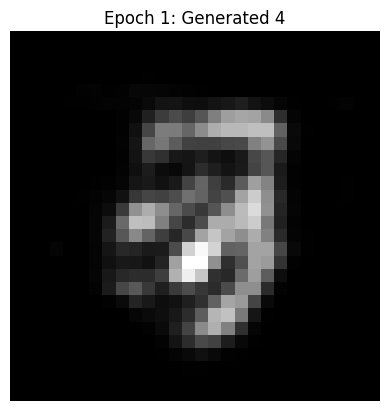

Epoch 21/300, Train Loss: 2.707330, Val Loss: 2.584332


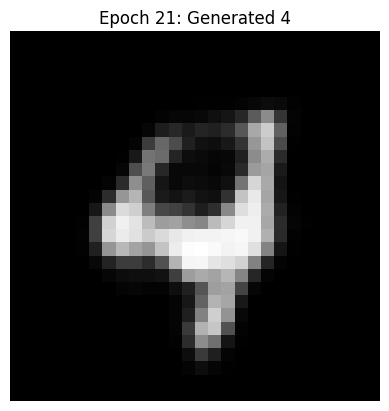

Epoch 41/300, Train Loss: 2.701750, Val Loss: 2.597314


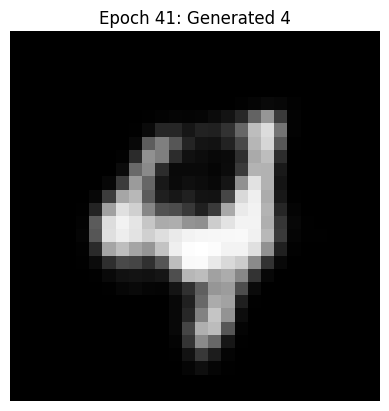

Early stopping at epoch 42
LabelToVector training complete


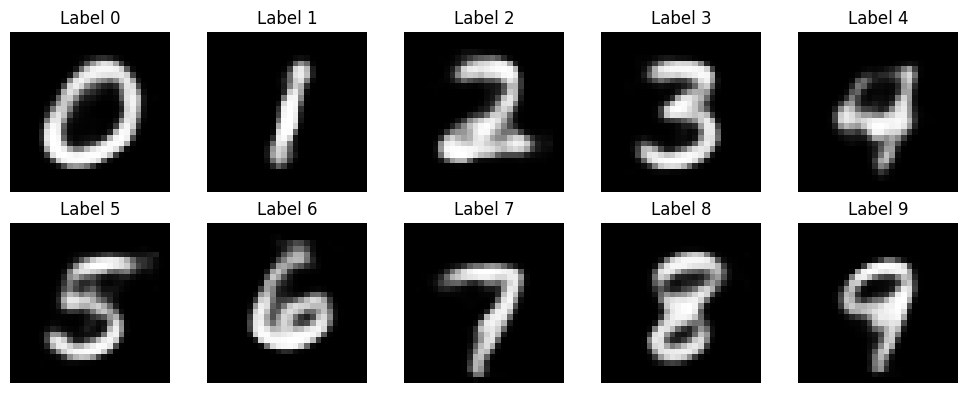

Latent MSE: 3.804784


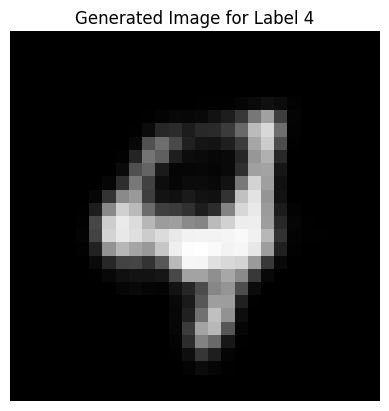

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

batch_size = 64
train_dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.inh1 = nn.Linear(28*28, 256)
        self.inh2 = nn.Linear(256, 128)
        self.inh3 = nn.Linear(128, 64)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.inh1(x))
        x = self.act(self.inh2(x))
        x = self.act(self.inh3(x))
        return x

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.inh1 = nn.Linear(64, 128)
        self.inh2 = nn.Linear(128, 256)
        self.inh3 = nn.Linear(256, 28*28)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.inh1(x))
        x = self.act(self.inh2(x))
        x = self.sigmoid(self.inh3(x))
        return x

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Training function for Autoencoder
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss = 0
    num_batches = len(dataloader)
    for i, (images, _) in enumerate(dataloader):
        img = images.view(-1, 28*28).to(device)
        pred = model(img)
        loss = loss_fn(pred, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        track_loss += loss.item()
        if i % 100 == 0:
            print(f"Batch {i}/{num_batches}, Running Loss: {loss.item():.6f}")
    return track_loss / num_batches

# Train Autoencoder
autoencoder = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20  # Increased epochs

for epoch in range(n_epochs):
    print(f"{'_'*30}\nEpoch {epoch+1}/{n_epochs}")
    avg_loss = train_one_epoch(train_dl, autoencoder, loss_fn, optimizer)
    scheduler.step()
    print(f"Average Loss: {avg_loss:.6f}")

print("Autoencoder training complete")

# Function to evaluate encoder and get latent vectors
def eval_encoder(dataloader, model):
    model.eval()
    li = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.view(-1, 784).to(device)
            labels = labels.to(device)
            latent = model.encoder(imgs)
            li.append([labels, latent])
    return li

# Get latent vectors from test set
li = eval_encoder(test_dl, autoencoder)
print(f"Collected {len(li)} latent vectors")

# Define combined loss for LabelToVector
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.cosine = nn.CosineSimilarity(dim=1)
        self.alpha = alpha

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        cosine_loss = 1 - self.cosine(pred, target).mean()
        return self.alpha * mse_loss + (1 - self.alpha) * cosine_loss

# Define LabelToVector model with batch normalization
class LabelToVector(nn.Module):
    def __init__(self):
        super().__init__()
        self.inh1 = nn.Linear(10, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.inh2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.inh3 = nn.Linear(128, 64)
        self.act = nn.ReLU()

    def forward(self, x):
        x = nn.functional.one_hot(x, num_classes=10).float()
        x = self.act(self.bn1(self.inh1(x)))
        x = self.act(self.bn2(self.inh2(x)))
        x = self.act(self.inh3(x))
        return x

# Training function for LabelToVector with validation and early stopping
def train_label_to_vector(train_dl, val_dl, model, loss_fn, optimizer, scheduler, epochs=300, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for labels, latents in train_dl:
            labels, latents = labels.to(device), latents.to(device)
            pred = model(labels)
            loss = loss_fn(pred, latents)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for labels, latents in val_dl:
                labels, latents = labels.to(device), latents.to(device)
                pred = model(labels)
                val_loss += loss_fn(pred, latents).item()

        train_loss /= len(train_dl)
        val_loss /= len(val_dl)
        scheduler.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            with torch.no_grad():
                sample_label = torch.tensor([4]).to(device)
                latent = model(sample_label)
                image = autoencoder.decoder(latent).view(28, 28).cpu()
                plt.imshow(image, cmap="gray")
                plt.title(f"Epoch {epoch+1}: Generated 4")
                plt.axis("off")
                plt.show()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

# Prepare data for LabelToVector with validation split
labels = torch.cat([item[0] for item in li])
latents = torch.cat([item[1] for item in li])
dataset = TensorDataset(labels, latents)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dl_ltv = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl_ltv = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Train LabelToVector
label_to_vector = LabelToVector().to(device)
ltv_optimizer = torch.optim.Adam(label_to_vector.parameters(), lr=0.001)
ltv_scheduler = torch.optim.lr_scheduler.StepLR(ltv_optimizer, step_size=50, gamma=0.5)
ltv_loss_fn = CombinedLoss(alpha=0.7)
train_label_to_vector(train_dl_ltv, val_dl_ltv, label_to_vector, ltv_loss_fn, ltv_optimizer, ltv_scheduler)
print("LabelToVector training complete")

# Function to generate image from label
def generate_image(label, label_to_vector, decoder):
    label_to_vector.eval()
    decoder.eval()
    with torch.no_grad():
        label_tensor = torch.tensor([label]).to(device)
        latent = label_to_vector(label_tensor)
        image = decoder(latent).view(28, 28).cpu()
    return image

# Visualize all digits
def visualize_all_digits(label_to_vector, decoder):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        img = generate_image(i, label_to_vector, decoder)
        ax = axes[i // 5, i % 5]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Evaluate latent alignment
def evaluate_latent_alignment(test_dl, autoencoder, label_to_vector):
    autoencoder.eval()
    label_to_vector.eval()
    total_mse = 0
    with torch.no_grad():
        for imgs, labels in test_dl:
            imgs = imgs.view(-1, 784).to(device)
            labels = labels.to(device)
            true_latent = autoencoder.encoder(imgs)
            pred_latent = label_to_vector(labels)
            total_mse += nn.MSELoss()(pred_latent, true_latent).item()
    print(f"Latent MSE: {total_mse / len(test_dl):.6f}")

# Final evaluation
visualize_all_digits(label_to_vector, autoencoder.decoder)
evaluate_latent_alignment(test_dl, autoencoder, label_to_vector)

# Generate and visualize an image for label 4
label = 4
generated_image = generate_image(label, label_to_vector, autoencoder.decoder)
plt.imshow(generated_image, cmap="gray")
plt.title(f"Generated Image for Label {label}")
plt.axis("off")
plt.show()

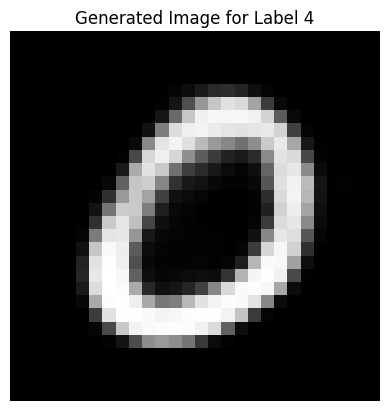

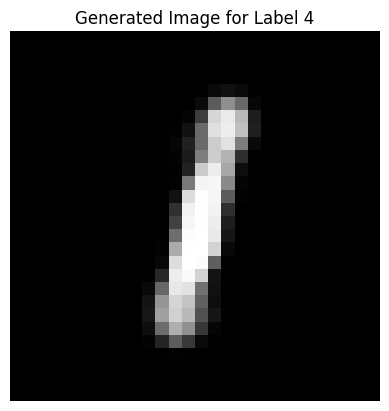

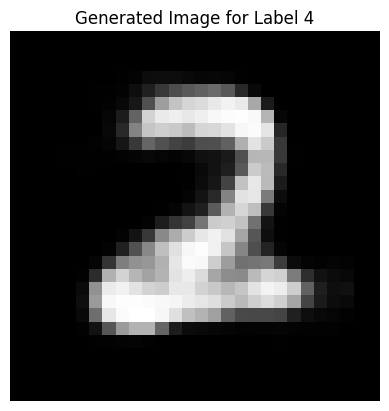

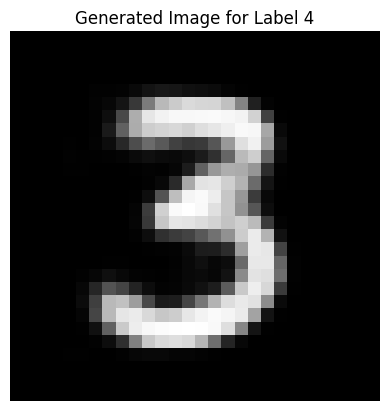

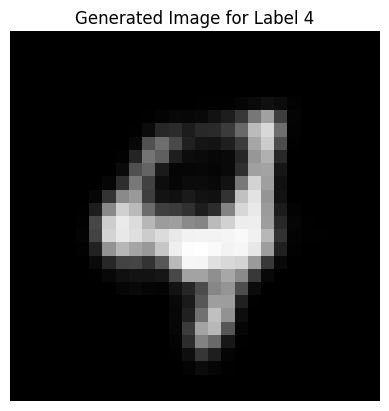

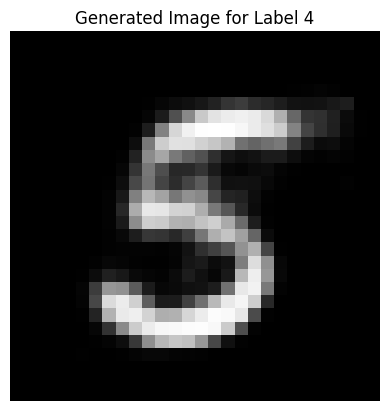

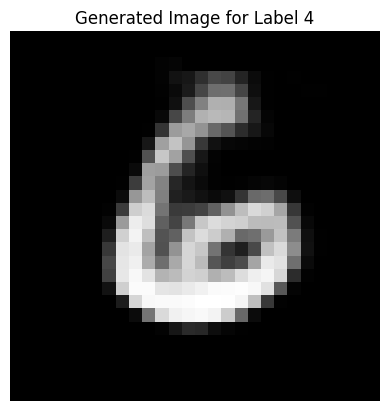

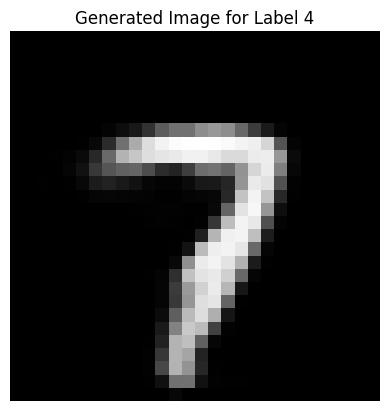

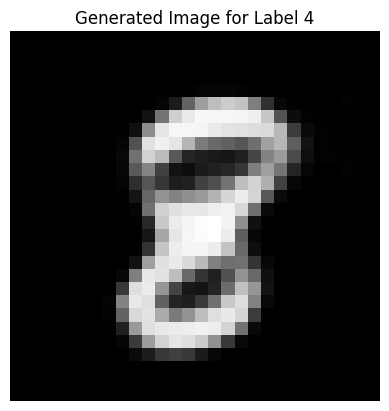

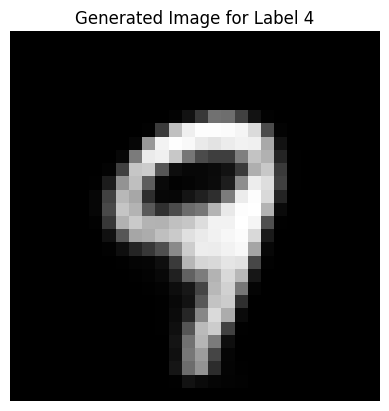

In [2]:
for i in range(0,10):
  generated_image = generate_image(i, label_to_vector, autoencoder.decoder)
  plt.imshow(generated_image, cmap="gray")
  plt.title(f"Generated Image for Label {label}")
  plt.axis("off")
  plt.show()